# Import Libraries

In [1]:
from google.colab import files
files.upload()  # Select kaggle.json from your system



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"prachetpandav","key":"d0a940019c21a30c427852dbb2fd13d7"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


In [4]:
import zipfile

dataset_zip = "/content/chest-xray-pneumonia.zip"  # Change this to the actual file name
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("chest_xray_dataset")

# Check extracted files
import os
print(os.listdir("chest_xray_dataset"))

['chest_xray']


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os


#Set Parameters and Paths

In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 10

DATASET_PATH = '/content/chest_xray_dataset/chest_xray'
train_dir = os.path.join(DATASET_PATH, 'train')
test_dir = os.path.join(DATASET_PATH, 'test')


# Prepare Data with Validation Split

In [7]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


# Load DenseNet121 Base Model

In [8]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze initial layers


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Build the Full Model

In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

# Train the Frozen Model First

In [10]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 169s 534ms/step - accuracy: 0.8442 - loss: 0.3582 - val_accuracy: 0.9386 - val_loss: 0.1803
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 125s 480ms/step - accuracy: 0.9320 - loss: 0.1713 - val_accuracy: 0.9386 - val_loss: 0.1527
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 103s 394ms/step - accuracy: 0.9394 - loss: 0.1517 - val_accuracy: 0.9463 - val_loss: 0.1425
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 100s 384ms/step - accuracy: 0.9506 - loss: 0.1404 - val_accuracy: 0.9569 - val_loss: 0.1181
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 101s 388ms/step - accuracy: 0.9552 - loss: 0.1255 - val_accuracy: 0.9540 - val_loss: 0.1126
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 104s 399ms/step - accuracy: 0.9554 - loss: 0.1181 - val_accuracy: 0.9530 - val_loss: 0.1262
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 104s 398ms/step - accuracy: 0.9642 - loss: 0.1045 - val_accuracy: 0.9664 - val_loss: 0.0944
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 105s 401ms/step - accuracy: 0.9627 -

#Fine-Tune Top Layers of DenseNet

In [11]:
# Unfreeze top layers
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune training
fine_tune_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    callbacks=[early_stop]
)


Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 178s 533ms/step - accuracy: 0.9359 - loss: 0.1594 - val_accuracy: 0.9540 - val_loss: 0.1119
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 106s 406ms/step - accuracy: 0.9536 - loss: 0.1230 - val_accuracy: 0.9684 - val_loss: 0.0896
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 106s 407ms/step - accuracy: 0.9533 - loss: 0.1133 - val_accuracy: 0.9703 - val_loss: 0.0757
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 106s 407ms/step - accuracy: 0.9584 - loss: 0.1106 - val_accuracy: 0.9741 - val_loss: 0.0792
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 107s 410ms/step - accuracy: 0.9657 - loss: 0.1021 - val_accuracy: 0.9693 - val_loss: 0.0806


# Visualize Training

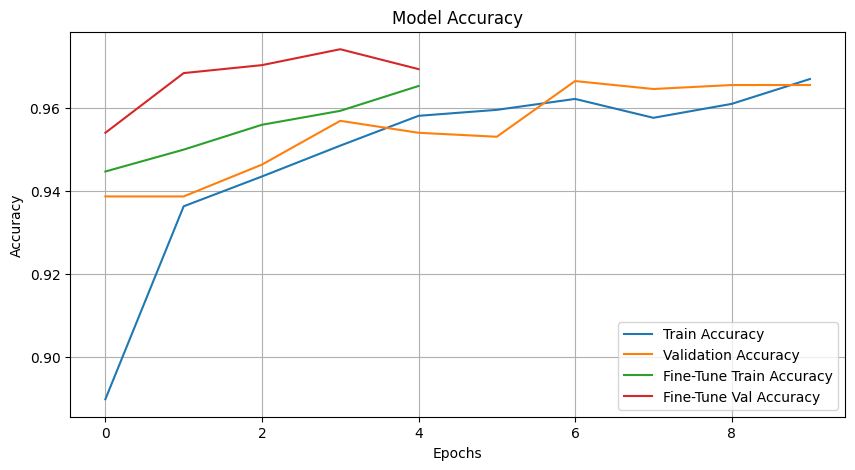

In [12]:
def plot_accuracy(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    if 'accuracy' in fine_tune_history.history:
        plt.plot(fine_tune_history.history['accuracy'], label='Fine-Tune Train Accuracy')
        plt.plot(fine_tune_history.history['val_accuracy'], label='Fine-Tune Val Accuracy')
    plt.legend()
    plt.grid(True)
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

plot_accuracy(history)


# Evaluate on Test Set

In [13]:
test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_data)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")


Found 624 images belonging to 2 classes.
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.8510 - loss: 0.4583
✅ Test Accuracy: 89.58%


In [14]:
# Save the trained model
model.save("pneumonia_model.h5")


# Predictive System

📦 Upload the trained model (.h5) and a chest X-ray image (jpeg/png):


Saving IM-0011-0001-0002.jpeg to IM-0011-0001-0002 (3).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

Prediction: 🦠 PNEUMONIA
Confidence: 88.40%


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129440 (\N{MICROBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


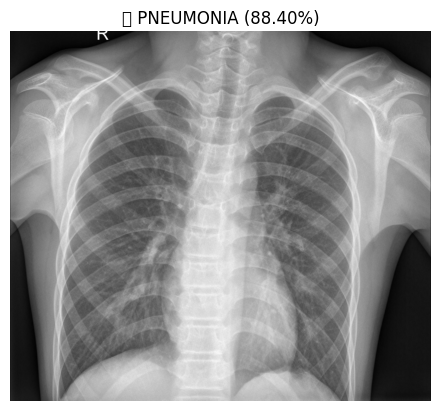

In [20]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image

# Upload model and image
print("📦 Upload the trained model (.h5) and a chest X-ray image (jpeg/png):")
uploaded = files.upload()

# Separate model and image from uploads
#model_file = [f for f in uploaded if f.endswith(".h5")][0]
image_file = [f for f in uploaded if f.lower().endswith((".jpg", ".jpeg", ".png"))][0]

# Load model
#model = load_model(model_file)

# Prepare image
img = Image.open(image_file).convert("RGB")
img_resized = img.resize((224, 224))
img_array = image.img_to_array(img_resized) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)[0][0]
result = "🦠 PNEUMONIA" if prediction >= 0.5 else "✅ NORMAL"
confidence = prediction if prediction >= 0.5 else 1 - prediction

# Display results
print(f"\nPrediction: {result}")
print(f"Confidence: {confidence * 100:.2f}%")

# Show image with label
plt.imshow(img)
plt.axis('off')
plt.title(f"{result} ({confidence * 100:.2f}%)")
plt.show()
